<a href="https://colab.research.google.com/github/PriyanshuRao-code/AI-Lab-Project/blob/Priyanshu-Rao/team_24_data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Don't do anything here. It is just a setup.
import os
import sys

repo_name = "AI-Lab-Project"
repo_url = "https://github.com/PriyanshuRao-code/AI-Lab-Project.git"
repo_path = f"/content/{repo_name}"
branch_name = "Priyanshu-Rao"

if os.path.exists(repo_path):
    print("Repository already exists at:", repo_path)
else:
    print("🚀 Cloning the repository...")
    os.system(f"git clone --branch {branch_name} --single-branch {repo_url}")

os.chdir(repo_path)
sys.path.append(repo_path)

print("Repository is ready to use at:", repo_path)

🚀 Cloning the repository...
Repository is ready to use at: /content/AI-Lab-Project


In [5]:
# Start your code from here

In [6]:
import numpy as np
import pandas as pd

In [7]:
df = pd.read_csv('24.csv')

In [8]:
df

,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),...,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Equinox,Hazardous
0,3703080,3703080,21.600,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,J2000,True
1,3723955,3723955,21.300,0.146068,0.326618,146.067964,326.617897,0.090762,0.202951,479.225620,...,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,J2000,False
2,2446862,2446862,20.300,0.231502,0.517654,231.502122,517.654482,0.143849,0.321655,759.521423,...,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,J2000,True
3,3092506,3092506,27.400,0.008801,0.019681,8.801465,19.680675,0.005469,0.012229,28.876199,...,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,J2000,False
4,3514799,3514799,21.600,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,J2000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4682,3759007,3759007,23.900,0.044112,0.098637,44.111820,98.637028,0.027410,0.061290,144.723824,...,164.183305,457.179984,0.741558,276.395697,1.581299,2.457708e+06,304.306025,0.787436,J2000,False
4683,3759295,3759295,28.200,0.006089,0.013616,6.089126,13.615700,0.003784,0.008460,19.977449,...,345.225230,407.185767,0.996434,42.111064,1.153835,2.458088e+06,282.978786,0.884117,J2000,False
4684,3759714,3759714,22.700,0.076658,0.171412,76.657557,171.411509,0.047633,0.106510,251.501180,...,37.026468,690.054279,0.965760,274.692712,2.090708,2.458300e+06,203.501147,0.521698,J2000,False
4685,3759720,3759720,21.800,0.116026,0.259442,116.025908,259.441818,0.072095,0.161210,380.662441,...,163.802910,662.048343,1.185467,180.346090,1.787733,2.458288e+06,203.524965,0.543767,J2000,False


In [9]:
print(df.columns.to_list())

['Neo Reference ID', 'Name', 'Absolute Magnitude', 'Est Dia in KM(min)', 'Est Dia in KM(max)', 'Est Dia in M(min)', 'Est Dia in M(max)', 'Est Dia in Miles(min)', 'Est Dia in Miles(max)', 'Est Dia in Feet(min)', 'Est Dia in Feet(max)', 'Close Approach Date', 'Epoch Date Close Approach', 'Relative Velocity km per sec', 'Relative Velocity km per hr', 'Miles per hour', 'Miss Dist.(Astronomical)', 'Miss Dist.(lunar)', 'Miss Dist.(kilometers)', 'Miss Dist.(miles)', 'Orbiting Body', 'Orbit ID', 'Orbit Determination Date', 'Orbit Uncertainity', 'Minimum Orbit Intersection', 'Jupiter Tisserand Invariant', 'Epoch Osculation', 'Eccentricity', 'Semi Major Axis', 'Inclination', 'Asc Node Longitude', 'Orbital Period', 'Perihelion Distance', 'Perihelion Arg', 'Aphelion Dist', 'Perihelion Time', 'Mean Anomaly', 'Mean Motion', 'Equinox', 'Hazardous']


In [10]:
df["Neo Reference ID"].equals(df['Name'])

True

In [11]:
filtered_df = df[df["Name"] == 3759007]

In [12]:
filtered_df

,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),...,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Equinox,Hazardous
4682,3759007,3759007,23.9,0.044112,0.098637,44.11182,98.637028,0.02741,0.06129,144.723824,...,164.183305,457.179984,0.741558,276.395697,1.581299,2.457708e+06,304.306025,0.787436,J2000,False


In [13]:
duplicate_list = df["Name"][df["Name"].duplicated()].unique()
print(duplicate_list)

[3666785 3373683 2489486 3514891 3645649 2003362 3551168 3736387 3102683
 2136818 2443103 3273782 2483656 3775199 2277810 2429736 3170221 3701883
 2365449 3763275 3432642 3358222 2162854 3182823 3025767 2488490 3716433
 3781651 2307070 3755345 3752441 2033342 3738913 3608784 3752445 2469219
 3761271 2162173 3773650 3279740 3455137 3751815 2363505 3773594 3761750
 3748472 2053409 2401954 3306214 2137099 3102681 3363380 2461353 2162361
 3426410 3653683 2486692 3394543 2458418 3623682 3709252 3752517 2395289
 3771633 2267223 3646599 3648862 2482796 2088254 2417655 3714553 2005604
 3662637 2189630 3743902 2369984 3312033 2469929 2004769 2356991 3081292
 3266944 3745113 3143084 3154513 2467352 3102762 3404494 3684008 3117446
 3117468 3072196 3092296 3125003 3768016 3774009 3068066 3120890 2488580
 3261402 2481025 3686271 2472263 3771017 2367943 3558387 3766334 3603128
 3354740 3549618 3065824 3408650 3764727 3307228 2345722 3025766 3276398
 2052381 2267221 3552523 3463371 3743123 3388356 36

In [14]:
df["Name"][df["Name"].duplicated()]

,Name
134,3666785
147,3373683
150,2489486
194,3514891
248,3645649
...,...
4667,3608622
4668,3475236
4678,3358223
4680,3608620


In [15]:
df[df["Name"] ==3662283]

,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),...,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Equinox,Hazardous
3849,3662283,3662283,20.7,0.192555,0.430566,192.555078,430.566244,0.119648,0.267541,631.742403,...,145.035928,814.019755,0.592216,110.72021,2.82014,2.457597e+06,178.503886,0.44225,J2000,False
4681,3662283,3662283,20.7,0.192555,0.430566,192.555078,430.566244,0.119648,0.267541,631.742403,...,145.035928,814.019755,0.592216,110.72021,2.82014,2.457597e+06,178.503886,0.44225,J2000,False


In [16]:
print(df.iloc[3849]['Close Approach Date'])
print(df.iloc[4681]['Close Approach Date'])

2014-03-08
2016-09-08


In [17]:

row1 = df.iloc[3849]
row2 = df.iloc[4681]

diff = row1 != row2

diff_list = diff.index[diff.values == True].tolist()

In [18]:
for list1 in diff_list:
  print(f"Difference in {list1} is {df.iloc[3849][list1]}")
  print(f"Difference in {list1} is {df.iloc[4681][list1]}")
  print("\n\n")

Difference in Close Approach Date is 2014-03-08
Difference in Close Approach Date is 2016-09-08



Difference in Epoch Date Close Approach is 1394265600000
Difference in Epoch Date Close Approach is 1473318000000



Difference in Relative Velocity km per sec is 17.4309711929
Difference in Relative Velocity km per sec is 26.0160578577



Difference in Relative Velocity km per hr is 62751.4962944688
Difference in Relative Velocity km per hr is 93657.8082878237



Difference in Miles per hour is 38991.3394614159
Difference in Miles per hour is 58195.3198219536



Difference in Miss Dist.(Astronomical) is 0.265947832
Difference in Miss Dist.(Astronomical) is 0.1675637506



Difference in Miss Dist.(lunar) is 103.453704834
Difference in Miss Dist.(lunar) is 65.1822967529



Difference in Miss Dist.(kilometers) is 39785228.0
Difference in Miss Dist.(kilometers) is 25067180.0



Difference in Miss Dist.(miles) is 24721394.0
Difference in Miss Dist.(miles) is 15576024.0





In [19]:
df.shape

(4687, 40)

In [20]:
df_another = df.drop_duplicates()

In [21]:
df_another.shape

(4687, 40)

In [22]:
print(df.duplicated().sum())

0


In [23]:
diff_set1 = set()

# Grouping by 'Name' to compare only within same Names
grouped1 = df.groupby("Name")

for name, group in grouped1:
    if group["Hazardous"].nunique() > 1:  # Check if 'Hazardous' has different values
        for i in range(len(group) - 1):
            row1 = group.iloc[i]
            for j in range(i + 1, len(group)):
                row2 = group.iloc[j]

                diff = row1 != row2
                diff_columns = diff.index[diff.values == True].tolist()

                diff_set1.update(diff_columns)

print(f"Columns which are different when 2 'Name's  are same but 'Hazardous' is different - \n{diff_set1}")


Columns which are different when 2 'Name's  are same but 'Hazardous' is different - 
set()


In [24]:
diff_set2 = set()
grouped2 = df.groupby("Name")
for name, group in grouped1:
    for i in range(len(group) - 1):
        row1 = group.iloc[i]
        for j in range(i + 1, len(group)):
            row2 = group.iloc[j]

            diff = row1 != row2
            diff_columns = diff.index[diff.values == True].tolist()

            diff_set2.update(diff_columns)

print(f"Columns which are different when 2 'Name's are same - \n{diff_set2}")

Columns which are different when 2 'Name's are same - 
{'Miss Dist.(kilometers)', 'Miss Dist.(Astronomical)', 'Miss Dist.(lunar)', 'Close Approach Date', 'Relative Velocity km per hr', 'Miss Dist.(miles)', 'Relative Velocity km per sec', 'Epoch Date Close Approach', 'Miles per hour'}


In [38]:
df_dropped = df.drop(columns=['Neo Reference ID'])

numerical_cols = df_dropped.select_dtypes(include=['number'])

# Correlation matrix
correlation_matrix = numerical_cols.corr()
mask = np.triu(np.ones(correlation_matrix.shape), k=0)

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        row = correlation_matrix.index[i]
        col = correlation_matrix.columns[j]
        value = correlation_matrix.iloc[i, j]
        if row != col:  # Ignore Self-correlation
          if value >=1:
            print(f"({row}, {col}) -> Correlation: {value}")

(Est Dia in KM(max), Est Dia in KM(min)) -> Correlation: 1.0000000000000047
(Est Dia in M(min), Est Dia in KM(min)) -> Correlation: 1.0000000000000027
(Est Dia in M(max), Est Dia in KM(max)) -> Correlation: 1.000000000000003
(Est Dia in M(max), Est Dia in M(min)) -> Correlation: 1.000000000000007
(Est Dia in Miles(min), Est Dia in KM(min)) -> Correlation: 1.0000000000000009
(Est Dia in Miles(min), Est Dia in KM(max)) -> Correlation: 1.0000000000000002
(Est Dia in Miles(min), Est Dia in M(max)) -> Correlation: 1.0000000000000036
(Est Dia in Miles(max), Est Dia in KM(min)) -> Correlation: 1.0000000000000029
(Est Dia in Miles(max), Est Dia in KM(max)) -> Correlation: 1.0000000000000007
(Est Dia in Feet(min), Est Dia in KM(min)) -> Correlation: 1.0000000000000087
(Est Dia in Feet(min), Est Dia in KM(max)) -> Correlation: 1.0000000000000036
(Est Dia in Feet(min), Est Dia in M(min)) -> Correlation: 1.0000000000000027
(Est Dia in Feet(min), Est Dia in M(max)) -> Correlation: 1.000000000000002

In [26]:
df_new = df_dropped[['Est Dia in KM(min)'] + ['Est Dia in KM(max)']]

In [27]:
df_new

,Est Dia in KM(min),Est Dia in KM(max)
0,0.127220,0.284472
1,0.146068,0.326618
2,0.231502,0.517654
3,0.008801,0.019681
4,0.127220,0.284472
...,...,...
4682,0.044112,0.098637
4683,0.006089,0.013616
4684,0.076658,0.171412
4685,0.116026,0.259442


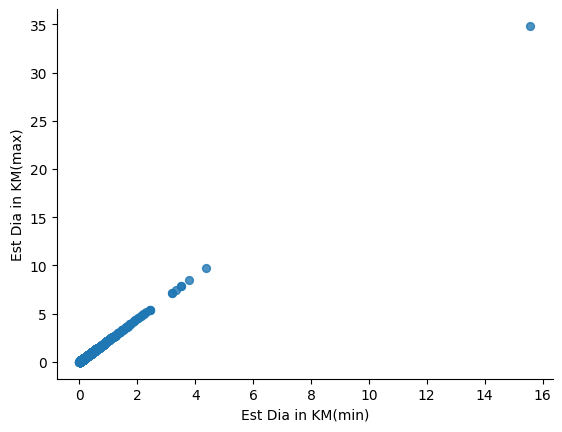

In [28]:
from matplotlib import pyplot as plt
df_new.plot(kind='scatter', x='Est Dia in KM(min)', y='Est Dia in KM(max)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

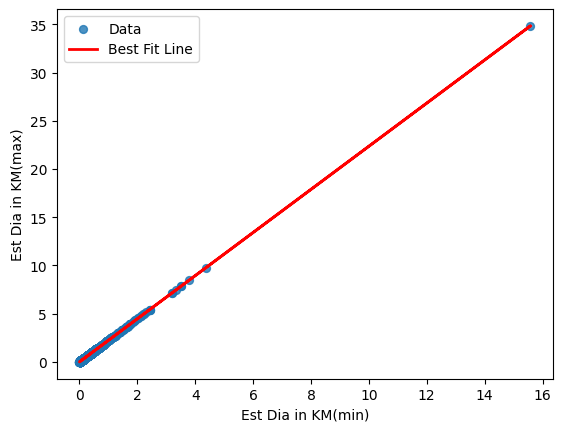

In [29]:
from sklearn.linear_model import LinearRegression

# Input (X) and Output (Y)
X = df_new[['Est Dia in KM(min)']]  # Independent variable
y = df_new['Est Dia in KM(max)']    # Dependent variable

# Linear Regression Model
model = LinearRegression()
model.fit(X, y)

# Get Slope (Weight) and Intercept

# Plot Regression Line
plt.scatter(X, y, s=32, alpha=0.8, label="Data")
plt.plot(X, model.predict(X), color='red', linewidth=2, label="Best Fit Line")
plt.xlabel('Est Dia in KM(min)')
plt.ylabel('Est Dia in KM(max)')
plt.legend()
plt.show()


In [34]:
df_new2 = df_dropped[['Est Dia in KM(min)'] + ['Est Dia in Feet(max)']]

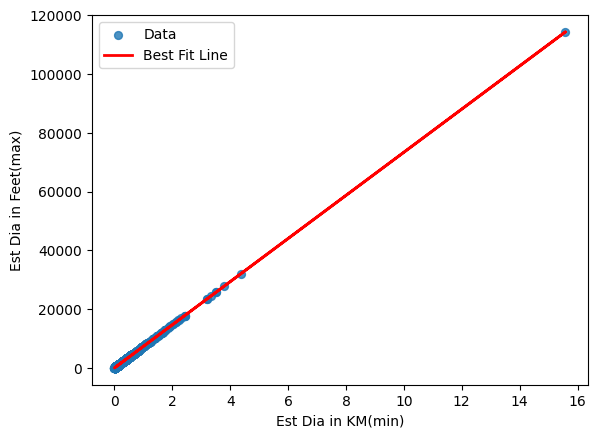

In [35]:
X = df_new2[['Est Dia in KM(min)']]  # Independent variable
y = df_new2[['Est Dia in Feet(max)']]    # Dependent variable

# Linear Regression Model
model = LinearRegression()
model.fit(X, y)

# Get Slope (Weight) and Intercept

# Plot Regression Line
plt.scatter(X, y, s=32, alpha=0.8, label="Data")
plt.plot(X, model.predict(X), color='red', linewidth=2, label="Best Fit Line")
plt.xlabel('Est Dia in KM(min)')
plt.ylabel('Est Dia in Feet(max)')
plt.legend()
plt.show()
